# QUESTION 1

Below is some helper code shared between the 2 functions


In [3]:
from typing import List
from math import sin, cos, tan, radians, pi, sqrt, degrees

import matplotlib.pyplot as plot
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Circle

In [4]:
def plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum, radius=2.5) -> None:

    # Graph the path of the robot
    figure, axes = plot.subplots()
    
    figure.set_size_inches(9, 9)
    axes.set_title("Path")
    axes.set_xlim((-3, 3))
    axes.set_ylim((-3, 3))
    axes.add_patch(Circle((0, 0), radius, facecolor="none", ec='k', lw=2))
    for index, path in enumerate(path_x):
        axes.plot(path_x[index], path_y[index], lw=4)

    # Flatten lists
    path_x = [item for sublist in path_x for item in sublist]
    path_y = [item for sublist in path_y for item in sublist]
    angular_momentum = [item for sublist in angular_momentum for item in sublist]

    # Plot angular momentum by command (each command has constant angular momentum)
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(angular_momentum)
    axes.set_title("Angular Momentum")
    axes.set_xlabel("Time step")

    # Plot x position by time
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(path_x, label="x")
    axes.set_xlabel("Time step")
    axes.set_title("Position X")

    # Plot y position by time
    figure, axes = plot.subplots()
    figure.set_size_inches(9, 9)
    axes.plot(path_y, label="y")
    axes.set_xlabel("Time step")
    axes.set_title("Position Y")

# Section A: Skid Steer Circle

In [5]:

class SkidRobot:
    def __init__(self, length, width, x=0, y=0) -> None:
        """Creates a robot

        Args:
            length (_type_): Uses Meters
            width (_type_): Uses Meters
        """
        self.length = length
        self.width = width
        self.x = x
        self.y = y
        self.theta = 0
    
    def move(self, velocity_left, velocity_right, dt=0.1) -> None:
        self.x -= (.5 * (velocity_left + velocity_right)) * sin(self.theta) * dt
        self.y += (.5 * (velocity_left + velocity_right)) * cos(self.theta) * dt
        self.theta += (1 / self.width) * (velocity_right - velocity_left) * dt
        
    def get_coords(self) -> "tuple[float, float]":
        return (self.x, self.y)
    
    def move_for_duration(self, duration, velocity_left, velocity_right, dt = 0.1) -> "tuple[list, list, list]":
        path_x = []
        path_y = []
        angular_momentum = []
        
        # put loop in terms of dt = 0.1
        current_time = 0
        while (current_time < duration):
            path_x.append(self.x)
            path_y.append(self.y)
            angular_momentum.append(self.get_angular_momentum(dt, velocity_left, velocity_right))
            self.move(velocity_left, velocity_right, dt)
            current_time += dt

        # Store final point
        path_x.append(self.x)
        path_y.append(self.y)
        return path_x, path_y, angular_momentum

    def get_bounds(self) -> "tuple[float, float]":
        return (self.width, self.length)

    def get_angular_momentum(self, duration, velocity_left, velocity_right) -> float:
        delta_theta = duration * ((velocity_right - velocity_left) / self.width)
        return radians(delta_theta)
    
    def calculate_error_move(self, vl, vr, dt=0.1):
        r = self.get_r(vl, vr)
        
        circumference = 2 * r * pi
        
        # Perform Move
        self.move(vl, vr, dt)
        
        # calculate theoretical position
        t_x, t_y = (r * sin(radians(self.theta)), r * -cos(radians(self.theta)))
        t_theta = (sqrt(t_x ** 2 + t_y ** 2) / circumference) * 360
        
        # Percent error calculation
        p_x = abs(1 - (abs(self.x - t_x) / abs(t_x))) * 100
        p_y = abs(1 - (abs(self.y - t_y) / abs(t_y))) * 100
        p_theta = abs(1 - (abs(self.theta - t_theta) / abs(t_theta))) * 100
        
        return [(p_x, p_y, p_theta), (t_x, t_y, t_theta), (self.x, self.y, degrees(self.theta))]

    def get_R(self, vr, vl):
        return (self.width / 2) * ((vr + vl) / (vr - vl))

In [6]:
robot = SkidRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


# Move 2.4m up, .3 seconds at 8 m/s 

# turn for 4 seconds at 6.1875 +- m/s

# 19 time steps

# Move to outside of the circle
duration, velocity_left, velocity_right = .3, 8, 8
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right)

path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

# Turn in place 90
duration, velocity_left, velocity_right = 1, 0.43197, -.43197

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right)


print(robot.theta)

path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

duration, velocity_left, velocity_right = 1.9, 8.92, 7.08
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(duration, velocity_left, velocity_right, 0.1)


path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)



-1.7278800000000003


## Plot the resulting path

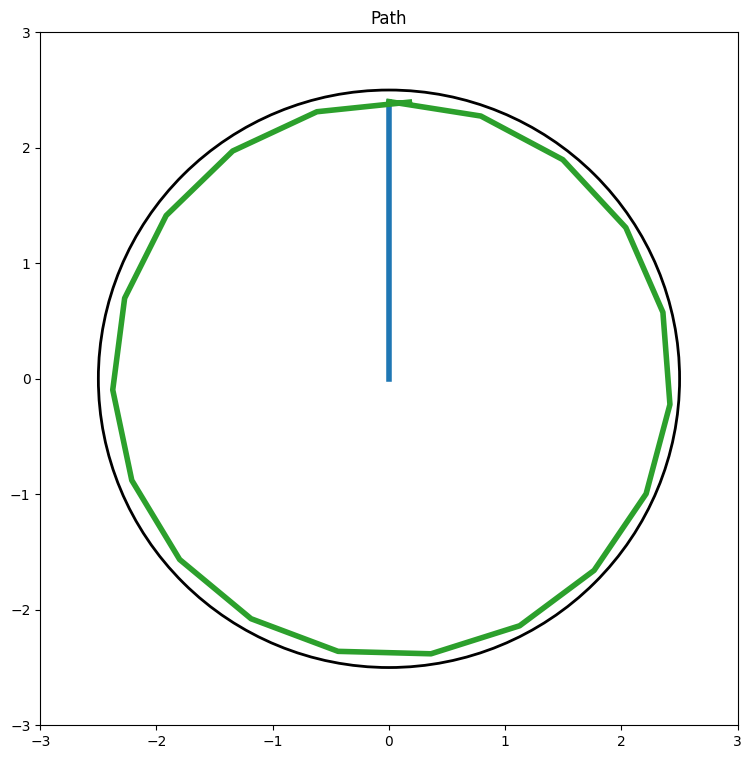

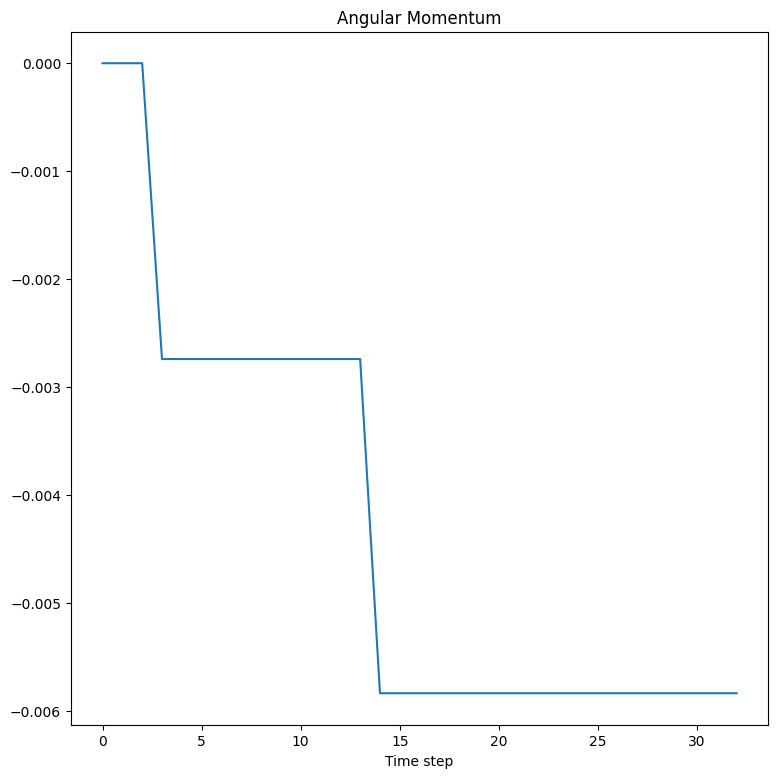

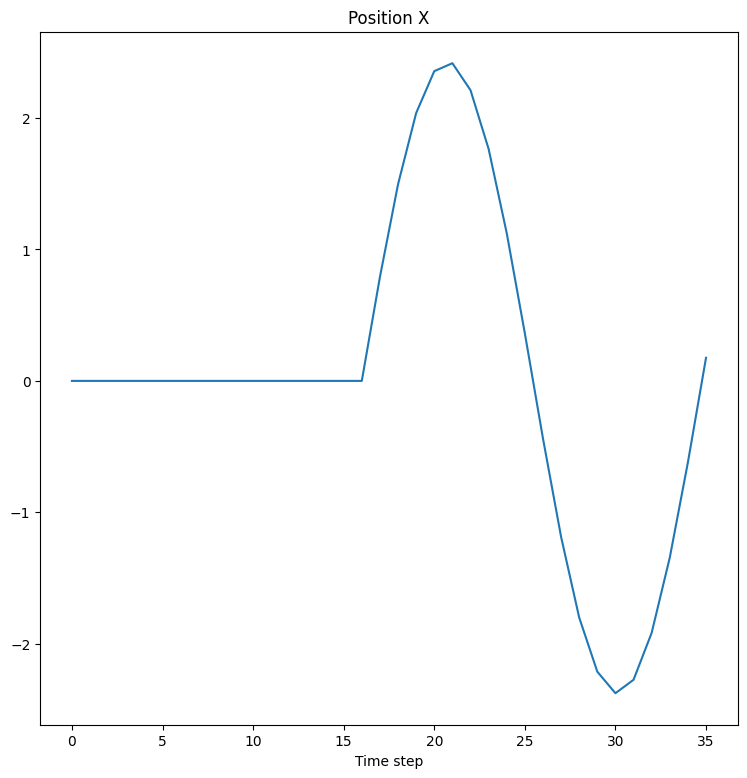

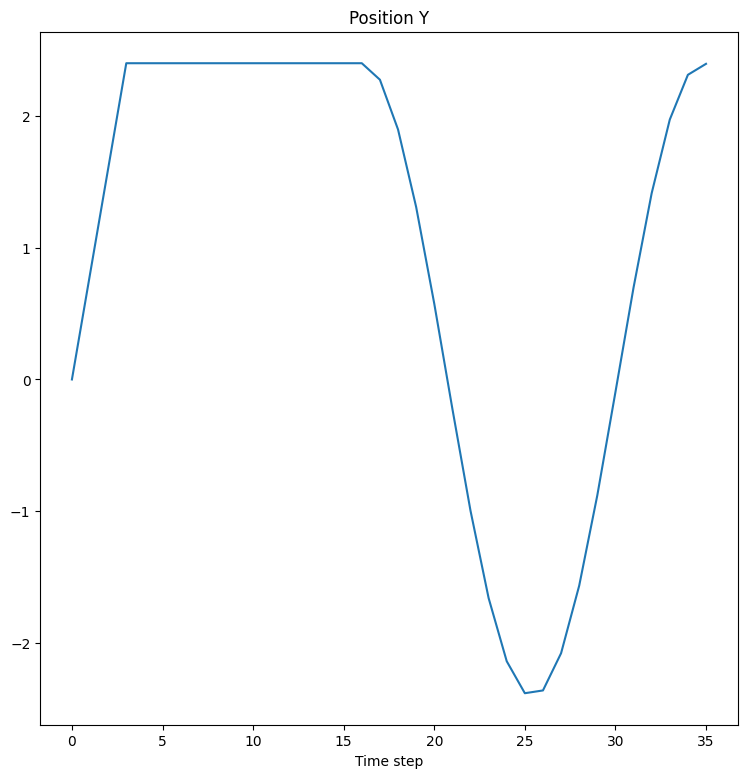

In [7]:
plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum)

# Section B: Ackerman Steering

In [8]:
class AckermanRobot:
    def __init__(self, length, width, x=0, y=0) -> None:
        """Creates a robot

        Args:
            length (_type_): Uses Meters
            width (_type_): Uses Meters
        """
        self.length = length
        self.width = width
        self.x = x
        self.y = y
        self.theta = 0

    def move(self, velocity: int, theta_w: int, dt=0.1) -> None:
        # Angle change for vehicle:
        simulation_timestep = 0.001
        for i in range(int(dt / simulation_timestep)):
            if theta_w:
                self.theta += (velocity / self.get_R(velocity, theta_w)) * simulation_timestep
                
            # Drive 🚓
            self.x -= velocity * sin(self.theta) * simulation_timestep
            self.y += velocity * cos(self.theta) * simulation_timestep
        


    def get_coords(self) -> "tuple[float, float]":
        return (self.x, self.y)

    def move_for_duration(
        self, duration, velocity, theta, dt=0.1
    ) -> "tuple[list, list, list]":
        path_x = []
        path_y = []
        angular_momentum = []

        # put loop in terms of dt = 0.1
        current_time = 0
        while current_time < duration:
            path_x.append(self.x)
            path_y.append(self.y)
            angular_momentum.append(
                self.get_angular_momentum(dt, velocity, theta)
            )
            self.move(velocity, theta, dt)
            current_time += dt

        # Store final point
        path_x.append(self.x)
        path_y.append(self.y)
        return path_x, path_y, angular_momentum

    def get_bounds(self) -> "tuple[float, float]":
        return (self.width, self.length)

    def get_angular_momentum(self, duration, velocity, theta_w) -> float:
        delta_theta = duration * (velocity / self.width)
        return delta_theta

    def calculate_error_move(self, vl, vr, dt=0.1):
        r = self.get_r(vl, vr)

        circumference = 2 * r * pi

        # Perform Move
        self.move(vl, vr, dt)

        # calculate theoretical position
        t_x, t_y = (r * sin(self.theta), r * -cos(self.theta))
        t_theta = (sqrt(t_x**2 + t_y**2) / circumference) * 360

        # Percent error calculation
        p_x = abs(1 - (abs(self.x - t_x) / abs(t_x))) * 100
        p_y = abs(1 - (abs(self.y - t_y) / abs(t_y))) * 100
        p_theta = abs(1 - (abs(self.theta - t_theta) / abs(t_theta))) * 100

        return [
            (p_x, p_y, p_theta),
            (t_x, t_y, t_theta),
            (self.x, self.y, self.theta),
        ]

    def get_R(self, v, theta):      
        return self.length / tan(theta)


## Attempt 1

(-1.6945817880399379, 1.1995284790655867): 495.41009714583817


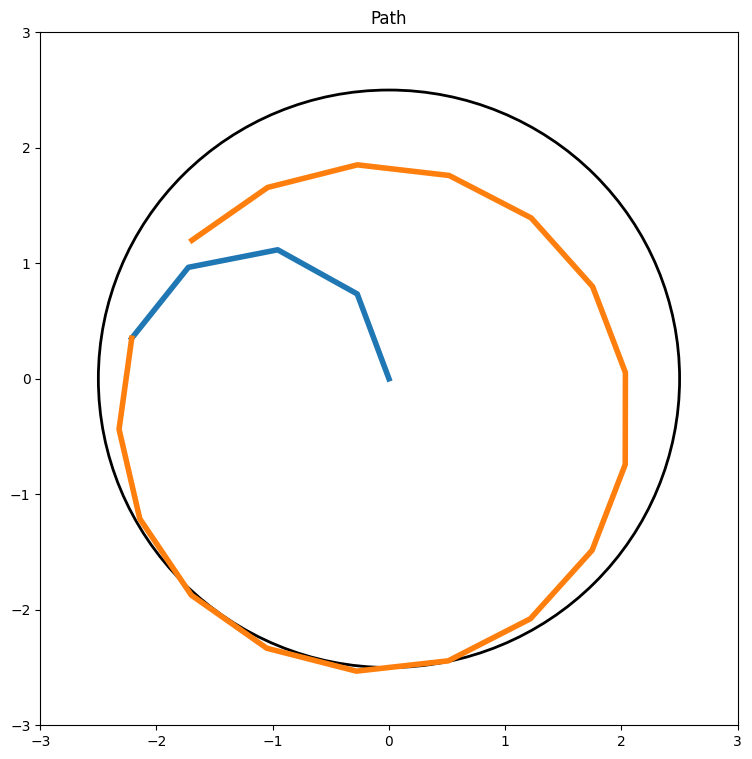

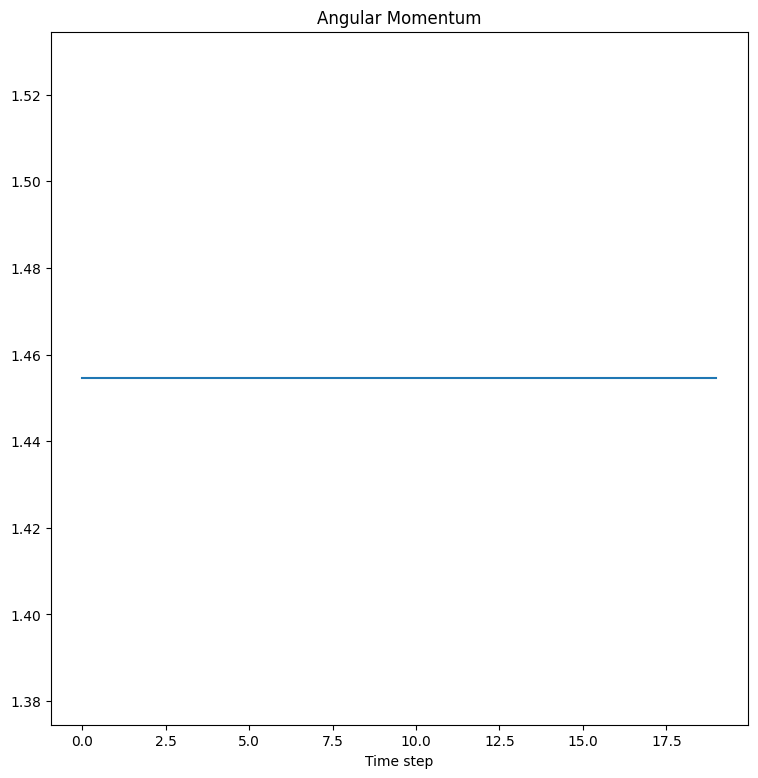

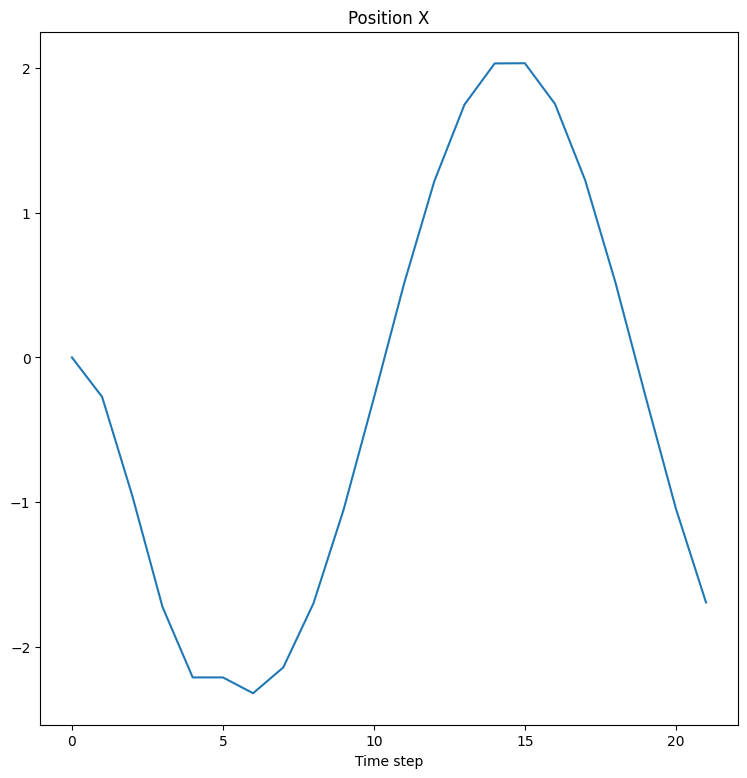

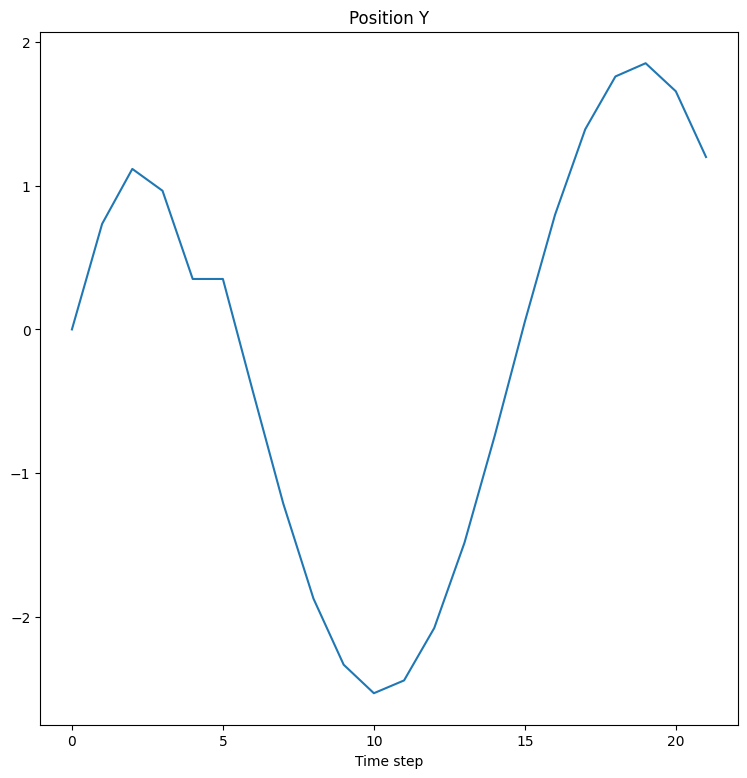

In [9]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


#First angle 0.634022719663 @ 0.4 sec

#Straight 0.1 sec

#Second angle 0.329771529972 @ ? sec

# Move to outside of the circle
# robot.theta = 0.634022719663
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.584, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

# print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
# sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.329, 0.1)
# path_x.append(sub_path_x)
# path_y.append(sub_path_y)
# print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
# angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(1.6, 8, 0.329, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")


plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum)


## Robot Path for Ackerman

Developer notes:
As we were calculating this solution, we found that if we were realistically driving to the outisde of the circle, with our given time step and velocity, this is the closest we could come to the outside of the circle.

Some fun solutions that were attempted but did not pan out were:
- Golden ration to the outside of the circle 
- Several smaller timesteps with verying thetas (too complex)

### Part B solution

(-2.3032521992044104, 0.7231594814420585): 504.7762767223585


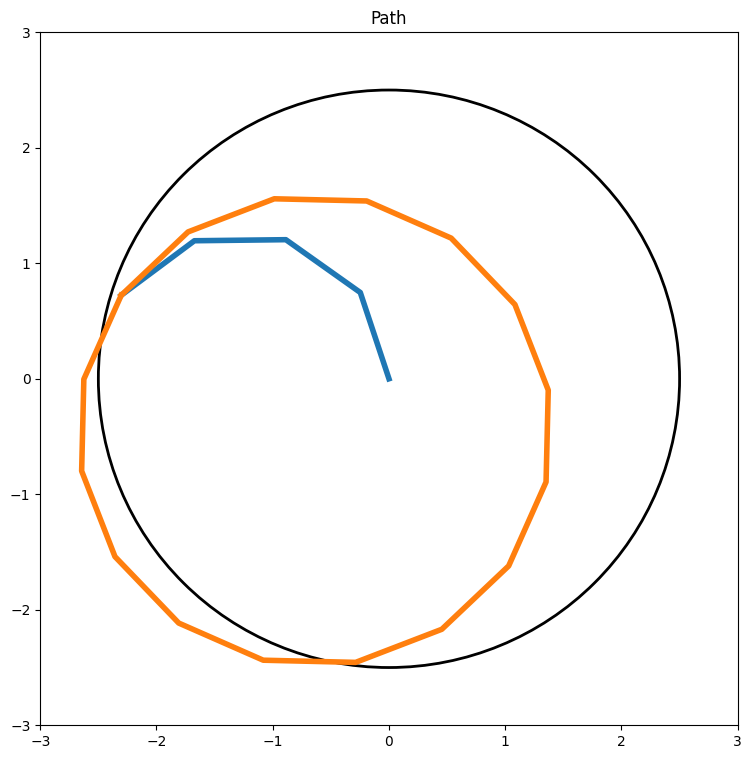

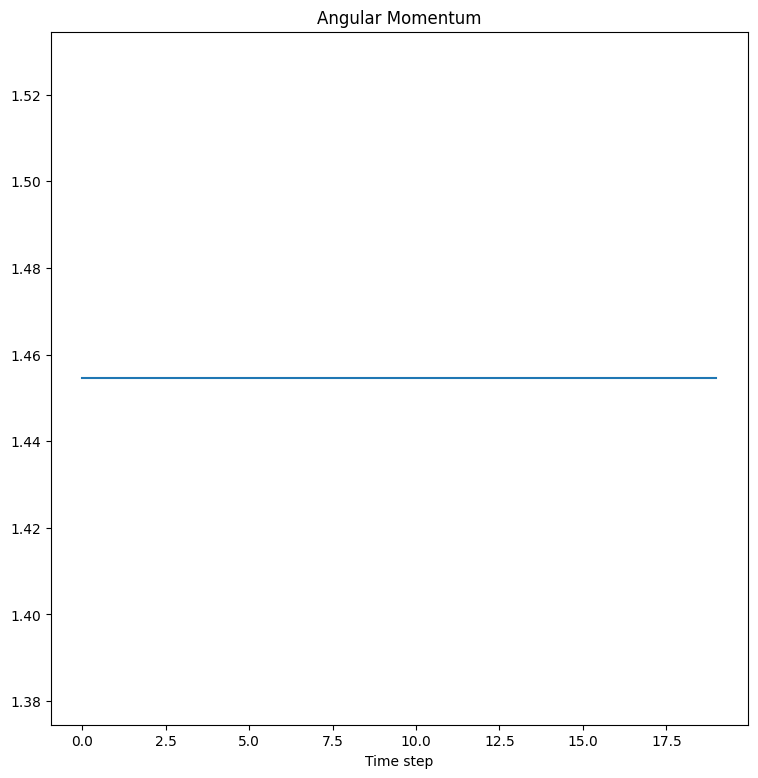

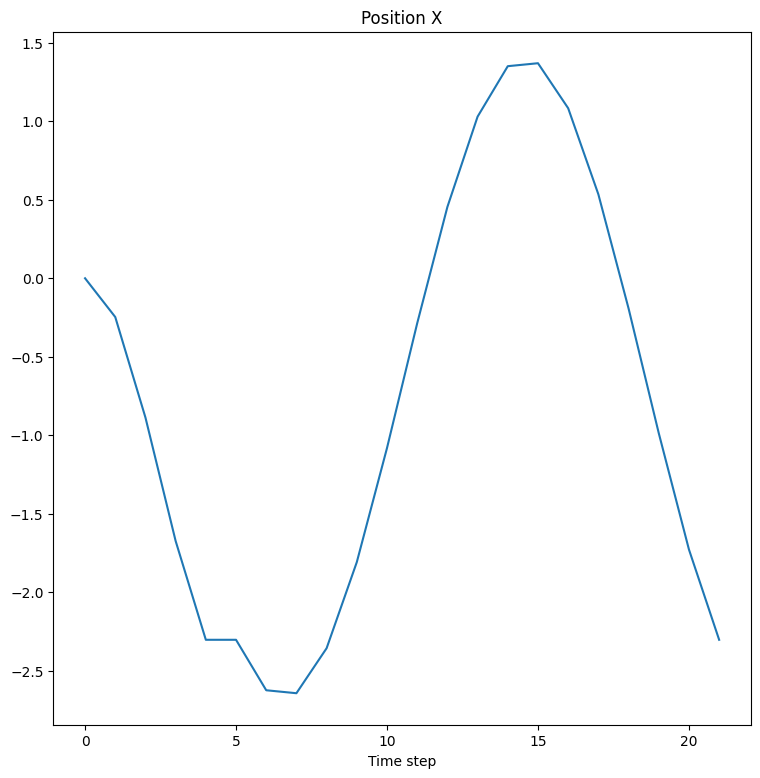

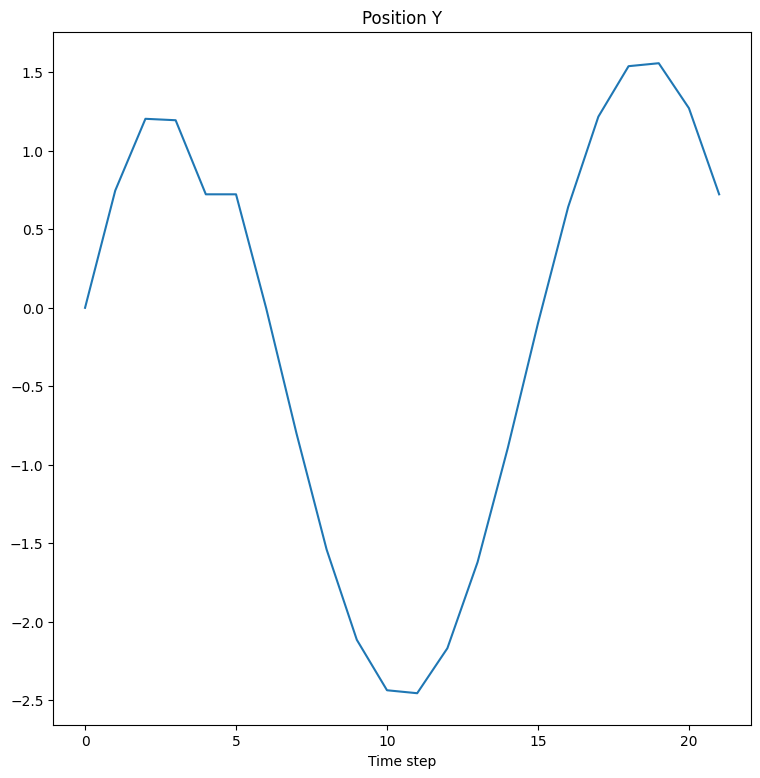

In [10]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


# Get as close as time step allows to outside of circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.534682287)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

# Drive in a circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(1.6, 8, 0.3527564542)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)


print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")


plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum)


However, if we are given just a *tiny* fracting more of room in our circle (give the circle a radius of 2.6), then we can go formward one more time step and really follow the ouside of the circle.

(-2.546470711651918, -0.00800000080867955): 540.0000000263531


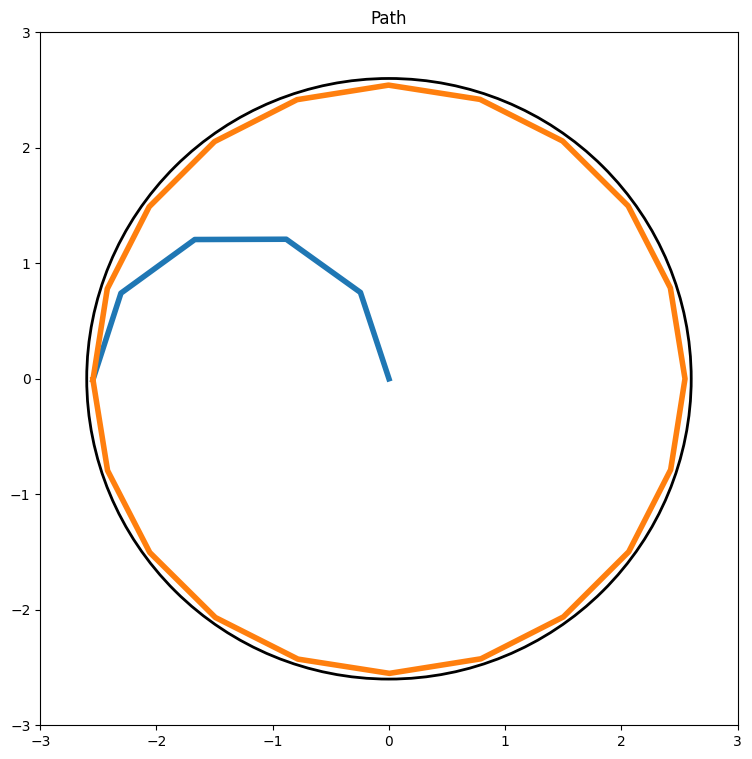

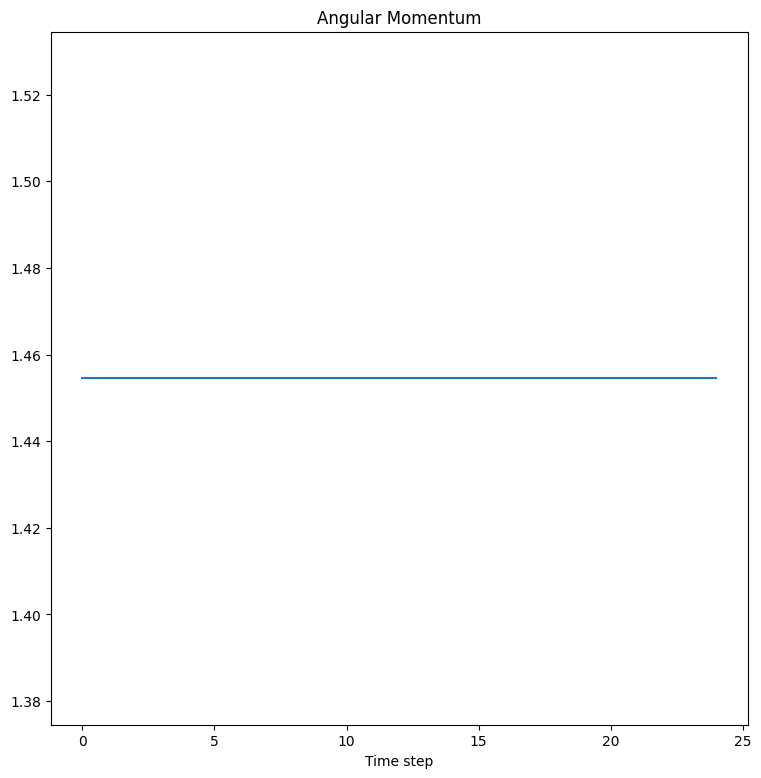

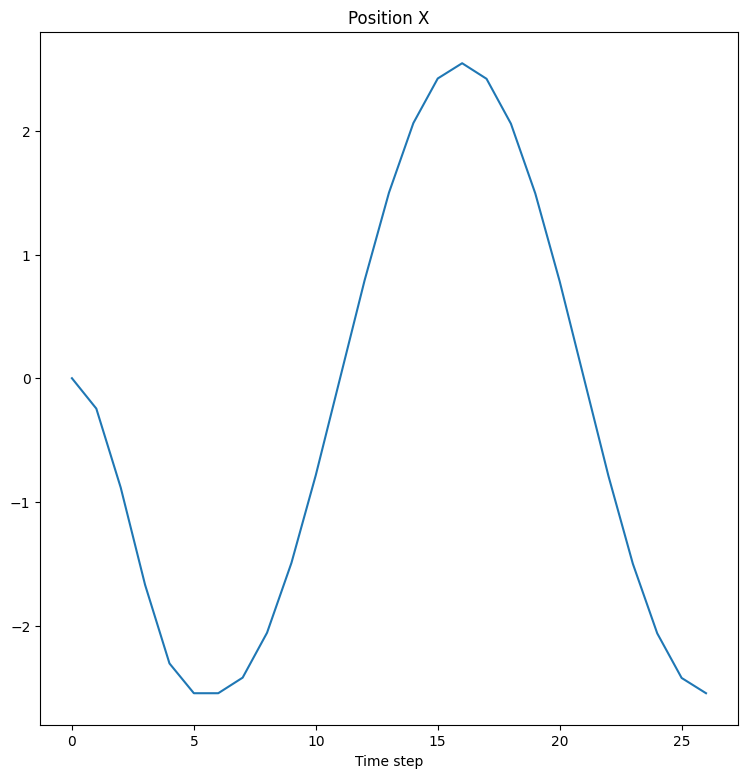

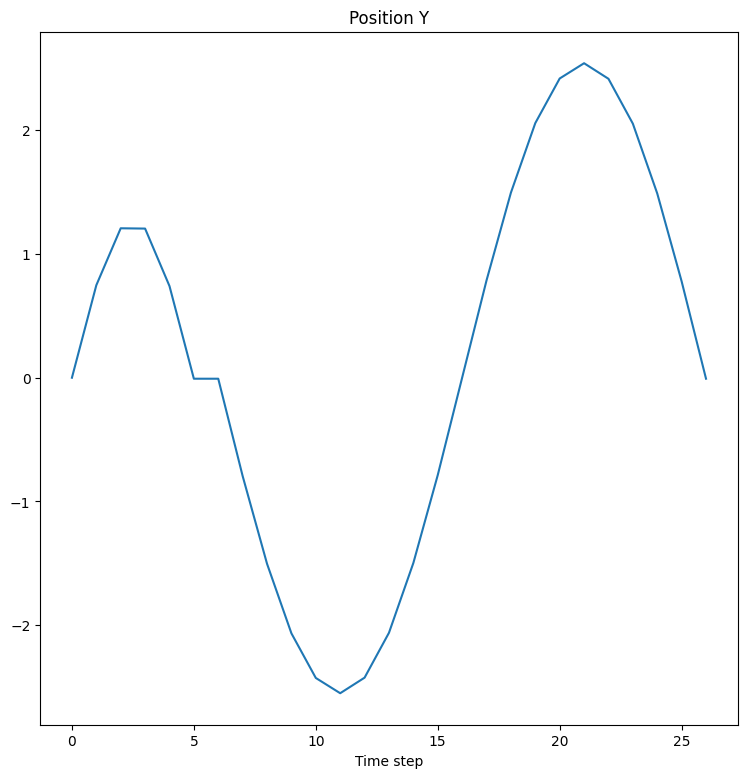

In [11]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []

# Get as close as time step allows to outside of circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.5, 8, 0.5323280991)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

# Drive in a circle
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(2, 8, 0.286425687)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)


print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")
plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum, 2.6)

## Potential Answer

(1.814541105754151, 1.600016105710471): 764.0022985419347


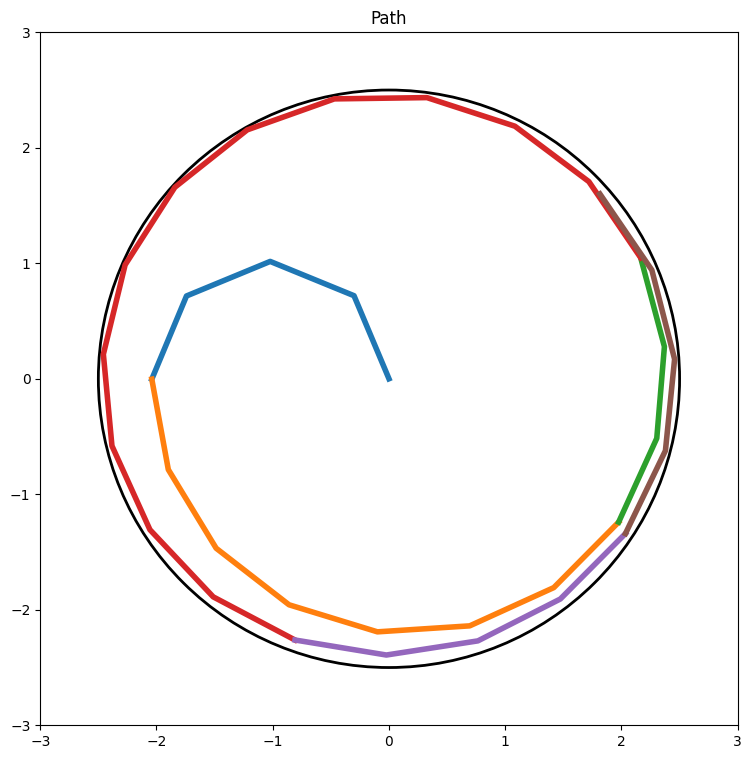

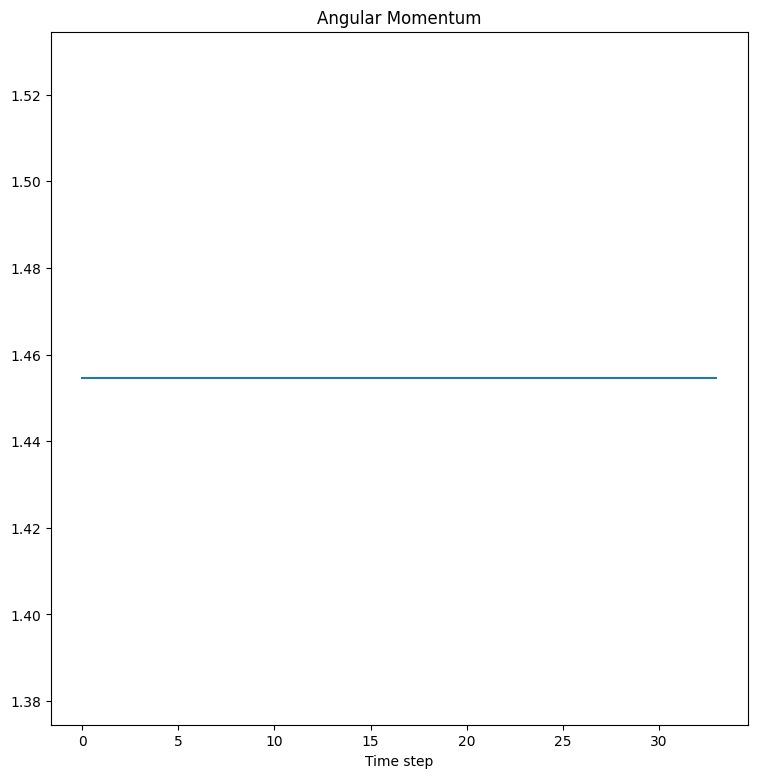

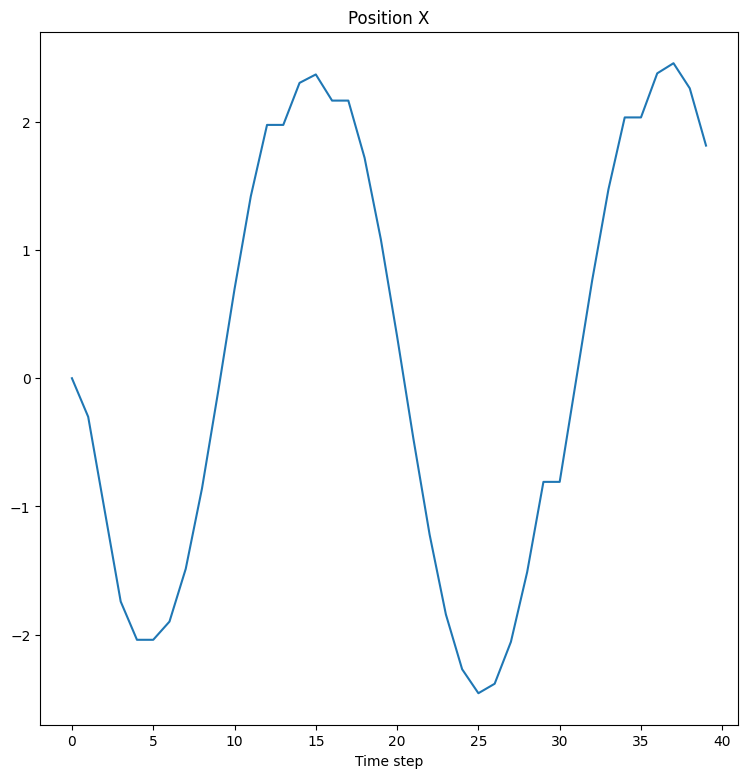

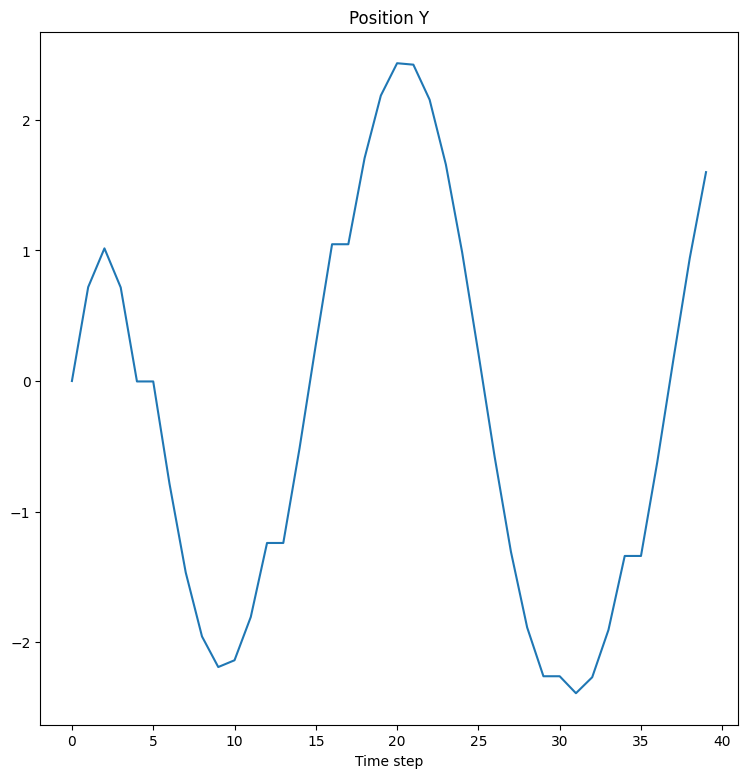

In [12]:
robot = AckermanRobot(.75, .55)
path_x = []
path_y = [] 
angular_momentum = []


#First angle 0.634022719663 @ 0.4 sec

#Straight 0.1 sec

#Second angle 0.329771529972 @ ? sec

# Move to outside of the circle
# robot.theta = 0.634022719663
sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(.4, 8, 0.634, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(0.7, 8, 0.329, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(0.3, 8, 0.31, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(1.1, 8, 0.3, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(0.4, 8, 0.29, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

sub_path_x, sub_path_y, sub_angular_momentum = robot.move_for_duration(0.4, 8, 0.315, 0.1)
path_x.append(sub_path_x)
path_y.append(sub_path_y)
angular_momentum.append(sub_angular_momentum)

print(f"({robot.x}, {robot.y}): {degrees(robot.theta)}")


plot_path_x_y_angular_velocities(path_x, path_y, angular_momentum)